<a href="https://colab.research.google.com/github/PCeltide/Coursera/blob/main/Machine%20Learning%20and%20Reinforcement%20Learning%20in%20Finance%20Specialization/Course%201%20-%20Guided%20Tour%20of%20Machine%20Learning%20in%20Finance/Lectures/Linear_Regression_Using_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import math # math was imported as m in the original code
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting later
# import pandas as pd # pandas was imported but not used in the provided snippets
import tensorflow as tf
print(f"Using TensorFlow version: {tf.__version__}")

Using TensorFlow version: 2.18.0


# Data Generation

In [48]:
def generate_data(n_points=5000,
                  n_features=3,
                  weights=np.array([1.0, 0.5, 0.2, 0.1]), # Bias is weights[0]
                  noise_std=0.1):

    print(f"Generating data with {n_points} points, {n_features} features.")
    # Bias term will be handled separately or added later, generate features first
    # Original code seemed to have slightly inconsistent dimensions/usage, simplifying here.
    # Let X be the features directly.
    X = np.random.uniform(low=-1.0, high=1.0, size=(n_points, n_features)) # Generate features between 0 and 1

    #print("DEBUG: Shape of generated X:", X.shape)
    #print("DEBUG: First 5 rows of generated X:\n", X[:5, :])

    # True bias (intercept)
    bias = weights[0]
    # True weights for features
    feature_weights = weights[1:].reshape(n_features, 1) # Ensure correct shape for dot product

    # Calculate the true underlying relationship (without noise)
    Y_true = bias + np.dot(X, feature_weights)

    # Add simulated Gaussian noise
    noise = np.random.normal(loc=0.0, scale=noise_std, size=(n_points, 1))
    Y = Y_true + noise

    print(f'Shapes: X={X.shape}, Y={Y.shape}')
    return X, Y

In [49]:
# Generate the data
n_points = 5000
n_features = 3
true_weights = np.array([1.0, 0.5, 0.2, 0.1]) # Intercept = 1.0, w1=0.5, w2=0.2, w3=0.1
noise_std_dev = 0.1
X_data, Y_data = generate_data(n_points=n_points, n_features=n_features,
                             weights=true_weights, noise_std=noise_std_dev)

# Split into training and testing sets
train_test_split_ratio = 4 # 1/4 for testing
n_test = n_points // train_test_split_ratio
n_train = n_points - n_test

X_train = X_data[:n_train]
Y_train = Y_data[:n_train]
X_test = X_data[n_train:]
Y_test = Y_data[n_train:]

print(f"Train shapes: X={X_train.shape}, Y={Y_train.shape}")
print(f"Test shapes: X={X_test.shape}, Y={Y_test.shape}")

Generating data with 5000 points, 3 features.
Shapes: X=(5000, 3), Y=(5000, 1)
Train shapes: X=(3750, 3), Y=(3750, 1)
Test shapes: X=(1250, 3), Y=(1250, 1)


# Normal Equation with TensorFlow

In [50]:
# Add the column of ones to the training data features
ones_column_train = tf.ones((n_train, 1), dtype=tf.float32)
X_train_b = tf.constant(X_train, dtype=tf.float32) # Ensure X_train is TF tensor
X_train_b = tf.concat([ones_column_train, X_train_b], axis=1)

In [51]:
# Convert Y_train to a TF tensor
Y_train_tf = tf.constant(Y_train, dtype=tf.float32)

In [52]:
# Calculate theta using TensorFlow operations (runs eagerly) NOTE: it would be better to solve the equation, though we follow the lecture
XT = tf.transpose(X_train_b)
XTX = tf.matmul(XT, X_train_b)
XTX_inv = tf.linalg.inv(XTX)
XTX_inv_XT = tf.matmul(XTX_inv, XT)
theta_tf_normal = tf.matmul(XTX_inv_XT, Y_train_tf)

In [53]:
print("Theta (coefficients including bias) from Normal Equation:")
# .numpy() gets the value from the eager tensor
print(theta_tf_normal.numpy())

Theta (coefficients including bias) from Normal Equation:
[[0.9995529 ]
 [0.50280136]
 [0.20192811]
 [0.09699274]]


An alternative to the above, and more efficient would be to use the following directly:

In [54]:
theta_tf_normal = tf.linalg.lstsq(X_train_b, Y_train_tf)

In [55]:
print("Theta (coefficients including bias) from Normal Equation:")
print(theta_tf_normal.numpy())

Theta (coefficients including bias) from Normal Equation:
[[0.9995531 ]
 [0.50280154]
 [0.20192806]
 [0.09699273]]


# Linear Regression with Gradient Descent (Keras API)

Keras is TensorFlow's recommended high-level API for building and training models, making common tasks much simpler. A Dense layer means every node in the layer is connected to every node in the previous layer (or in this case, the input). It performs a linear operation: $$\textrm{output}=activation(\textrm{input}⋅W+b).$$

For linear regression, the default activation is 'linear' (meaning no transformation, $f(x)=x$), so it just calculates $\textrm{output}=\textrm{input}⋅W+b$. This is exactly the linear regression equation!

Keras automatically creates the necessary weight matrix $W$ (often called the kernel) and bias vector b (the intercept) inside this layer. These are the trainable parameters TensorFlow will learn.

In [56]:
# This creates a basic type of Keras model where layers are stacked one after the other in sequence. For simple models like linear regression, it's very convenient.
input_layer = tf.keras.Input(shape=(n_features,))
# input_shapes :  This only needs to be specified for the very first layer in a Sequential model.
#                 It tells the layer what shape to expect for each individual input sample. Here, each sample is a vector with n_features (e.g., 3) elements.
dense_layer = tf.keras.layers.Dense(units=1)
# units = 1: This tells the layer we want it to output one value for each input sample (our predicted Y value)
model = tf.keras.Sequential([
    input_layer,
    dense_layer
    ])

In [57]:
# We need to specify:
# - optimizer: Algorithm to update the weights (e.g., Adam, SGD)
# - loss: Function to measure how wrong the predictions are (Mean Squared Error for linear regression)
model.compile(optimizer='adam', loss='mean_squared_error') # 'adam' is often a good default

print("Model Summary:")
model.summary()

Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4 (16.00 B)

 Trainable params: 4 (16.00 B)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Train the model
# We feed the training data (X_train, Y_train).
# epochs: An epoch is one complete pass through the entire X_train and Y_train dataset.
# batch_size: Instead of calculating the loss and updating weights after every single data point (which can be noisy) or
#             after the entire dataset (which can be slow and memory-intensive), training is usually done in mini-batches.
# validation_split: Optionally use part of the training data to monitor performance during training.
print("Training the Keras model...")
history = model.fit(X_train, Y_train,
                    epochs=100, # Adjust as needed
                    batch_size=32,
                    validation_split=0.2, # Use 20% of training data for validation
                    verbose=1) # Set verbose=1 or 2 to see progress per epoch

print("Training complete.")

Training the Keras model...
Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4804 - val_loss: 1.2987
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2422 - val_loss: 1.0758
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9999 - val_loss: 0.8846
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7994 - val_loss: 0.7206
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6631 - val_loss: 0.5816
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5270 - val_loss: 0.4652
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4339 - val_loss: 0.3680
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3472 - val_loss: 0.2884
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2621 - val_loss: 0.2243
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2087 - val_loss: 0.1728
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1650 - val_loss: 0.1316
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━

In [59]:
# Evaluate the model on the test set
print("\nEvaluating on Test Set:")
loss_on_test = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss (Mean Squared Error): {loss_on_test:.6f}")


Evaluating on Test Set:
Test Loss (Mean Squared Error): 0.010008


In [60]:
# Get the learned weights and bias
print("Learned weights (Keras model):")
weights_keras = model.get_weights()

# weights_keras is a list: [kernel (feature weights), bias]
learned_bias = weights_keras[1][0] # Bias is a scalar array
learned_weights = weights_keras[0].flatten() # Weights W1, W2, W3...

print(f"Bias (Intercept): {learned_bias:.6f}")
print(f"Feature Weights: {learned_weights}")

Learned weights (Keras model):
Bias (Intercept): 0.997848
Feature Weights: [0.5004856  0.2039957  0.09617338]


In [61]:
# Make predictions
Y_pred_keras = model.predict(X_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


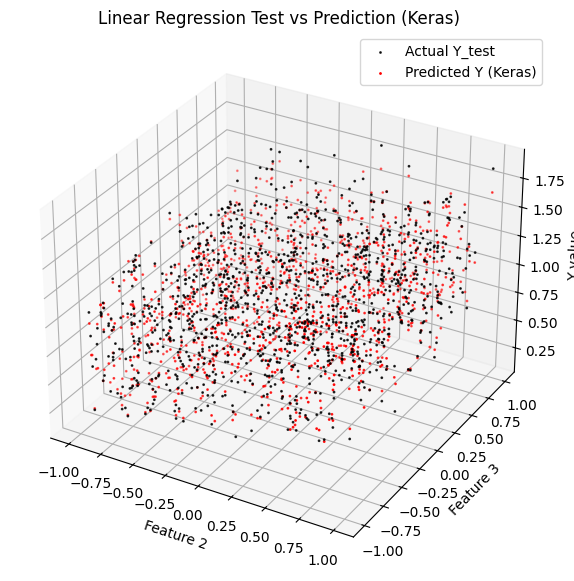

In [76]:
if n_features == 3: # Only plot if we have 3 features for the 3D scatter
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    # Plot using 2nd and 3rd features (index 1 and 2) vs the output Y
    ax.scatter(X_test[:, 1], X_test[:, 2], Y_test.ravel(), s=1, c='black', label='Actual Y_test', alpha = 0.8)
    ax.scatter(X_test[:, 1], X_test[:, 2], Y_pred_keras.ravel(), s=1, c='red', label='Predicted Y (Keras)')

    ax.set_xlabel(f'Feature {1+1}') # Adjust index if different features desired
    ax.set_ylabel(f'Feature {2+1}')
    ax.set_zlabel('Y value')
    ax.set_title('Linear Regression Test vs Prediction (Keras)')
    ax.legend()
    plt.show()
else:
    print("\nSkipping 3D plot because number of features is not 3.")